<a href="https://colab.research.google.com/github/CurtCalledBurt/DS-Unit-2-Applied-Modeling/blob/master/module2/assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()

Saving games.csv to games.csv


In [0]:
df = pd.read_csv('games.csv')

In [0]:
df.shape

(81312, 20)

In [0]:
df.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


In [0]:
df.columns.tolist()

['id',
 'type',
 'name',
 'yearpublished',
 'minplayers',
 'maxplayers',
 'playingtime',
 'minplaytime',
 'maxplaytime',
 'minage',
 'users_rated',
 'average_rating',
 'bayes_average_rating',
 'total_owners',
 'total_traders',
 'total_wanters',
 'total_wishers',
 'total_comments',
 'total_weights',
 'average_weight']

In [0]:
# My objective here is to see if I can predict how well a game will sell before it hits the market, so
# I will be predicting the "total_owners" column as my target. It's not a direct measure of game sales,
# but it's about the closest I could get while using data I had access to.

target = 'total_owners'


# With that objective in mind, there are a LOT of columns here that would come from the period after the game is
# released, like any of the ratings columns or anything having to do with the users, like users_rated, 
# total_wanters, total_traders, total_wishers, and total_comments. These all happen after a game is released. 

# I will also be removing the "total_weights", and the "average_weight" columns because this data set did
# not come with a document explaining what each column was. Fortunately most of the columns I am using are
# labeled well enough to know more or less what they are without that documentation. But in the case of these
# two columns, without an explanation of what "weight" is supposed to mean here it's impossible to know what it
# is, and therefore impossible to know if we would know about it before selling the game.

things_we_cannot_know = ['bayes_average_rating', 'average_rating', 'users_rated', 'total_traders', 
                         'total_wanters', 'total_wishers', 'total_comments', 'total_weights', 'average_weight'
]


# Lastly, we'll be removing the 'id', 'type', and 'name' columns. 'id' because it's just more or less a random 
# number that would mess with our model. 'type' carries no information in it as it is always the same: board game.
# And 'name' because every game name is different. Maybe we could leave 'name' in by using a categorical encoder 
# and not a one hot encoder, but I'm not sure how useful that might be. We may end up trying both and seeing how 
# much of a difference that makes just for kicks and giggles. 

things_we_do_not_need = ['id', 'type', 'name']


# What that leaves us to use as features then is just the properties of the boardgames themselves:
# How many people can play, how long does it take to play, who can play, etc.

features = df.columns.drop([target] + things_we_cannot_know + things_we_do_not_need)

X = df[features]
y = df[target]

In [0]:
df.isna().sum()

id                       0
type                     0
name                    41
yearpublished            3
minplayers               3
maxplayers               3
playingtime              3
minplaytime              3
maxplaytime              3
minage                   3
users_rated              0
average_rating           0
bayes_average_rating     0
total_owners             0
total_traders            0
total_wanters            0
total_wishers            0
total_comments           0
total_weights            0
average_weight           0
dtype: int64

In [0]:
# there are so few NaN's in the set that it feels like including or excluding them won't make a difference
# so we'll just fill each witht the median value when we create the model pipeline

In [0]:
from sklearn.model_selection import train_test_split

# Our data set is a pretty good size, but it's not big enough where I would feel doing a 
# train-test-val split would work well. So we'll be using crossvalidation instead.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60984, 7), (60984,), (20328, 7), (20328,))

In [0]:
X_train.head()

,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage
27418,1985.0,2.0,4.0,0.0,0.0,0.0,0.0
44480,0.0,2.0,4.0,15.0,15.0,15.0,4.0
9306,1982.0,1.0,4.0,120.0,120.0,120.0,12.0
73066,2014.0,2.0,99.0,30.0,30.0,30.0,14.0
42684,1989.0,2.0,4.0,15.0,15.0,15.0,7.0


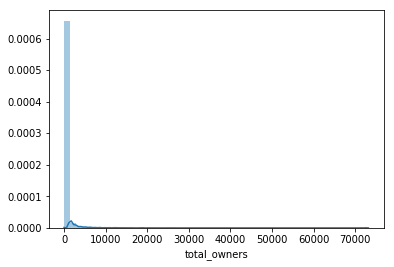

In [0]:
import seaborn as sns

sns.distplot(y_train);

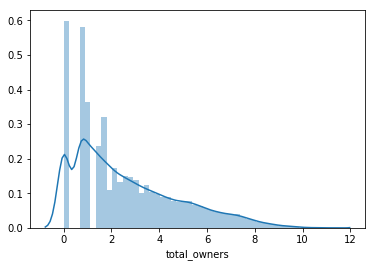

In [0]:
import seaborn as sns

sns.distplot(np.log(y_train + 1));

In [0]:
# I am next going to adjust my target slightly. I am going to change this continous variable total_owners 
# into a classification variable with 2 classes: low and high number of total owners. I'm doing this
# because I don't think the model predicting and giving us an exact output of total_owners as a 
# continuous variable is very reliable or insightful. However, telling us the game would be expected to sell
# a lot to a little is very insightful and would be quite helpful, especially since the data is very left skewed.

# These will be my thresholds for the classes. I've chosen these, basically just from personal experience.
# Games with over 10_000 copies sold in this list tended to be games I remember seeing on store shelves.
# After all, if your game appeals to a lot of people you'll likely have an easier time convincing local 
# game stores to stock it, and if they stock it, you'll likely sell a lot of copies of it. At around the 10_000
# mark I stopped seeing games I recognized from store shelves, so I set the cut_off there. 
# Not the most rigorous way of doing this, but as I do spend time in the board game section of any store  
# I happen to be walking through that has one, this metric seemed fine enough to me. 

# high >= 10_000
# low < 10_000

y_train = y_train >= 10_000 
y_test = y_test >= 10_000

In [0]:
# just doing a quick an dirty baseline estimation to see how many games actually
# are in my "high" class

def baseline_Logistic(labels):
  # making a list of the same size as 'labels' 
  # with only the mode as the only possible entree
  labels = labels.copy()  
  
  most_common_label = labels.mode()[0]
  pred_baseline = [most_common_label] * len(labels)
  
  labels = labels.reset_index()
  features = labels.columns.drop(['index'])
  labels = labels[features]  
    

  #calculate baseline accuracy
  wrong_count = 0
  for col in labels.columns:
    for i in range(len(pred_baseline)):
      if pred_baseline[i] != labels[col][i]:
        wrong_count += 1
    acc = 1 - wrong_count / len(pred_baseline)
  
  print('Accuracy of Baseline: ', acc*100, '%')
  return(pred_baseline)

In [0]:
y_pred_base = baseline_Logistic(y_train)

Accuracy of Baseline:  99.6343303161485 %


In [0]:
# just doing a quick an dirty baseline estimation to see how many games actually
# are in my "high" class

def confusion_matrix_labeled(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    rows = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                        columns=columns, index=rows)
    return table

In [0]:
confusion_matrix_labeled(y_train, y_pred_base)

,Predicted False,Predicted True
Actual False,60761,0
Actual True,223,0


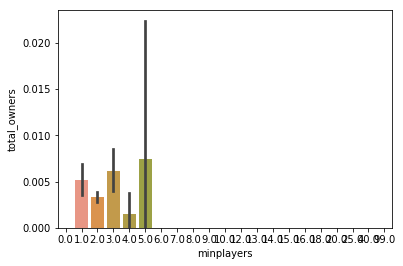

In [0]:
# the rest is data exploration for now.

import seaborn as sns

sns.barplot(X_train['minplayers'], y_train);

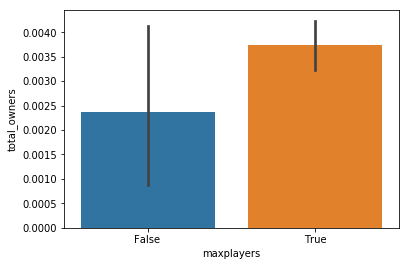

In [0]:
sns.barplot(X_train['maxplayers'] < 10, y_train);

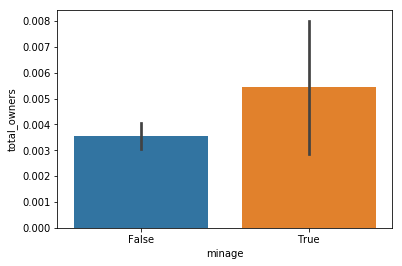

In [0]:
sns.barplot(X_train['minage']>=14, y_train);

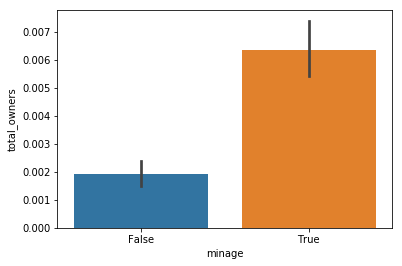

In [0]:
sns.barplot(X_train['minage']>=10, y_train);

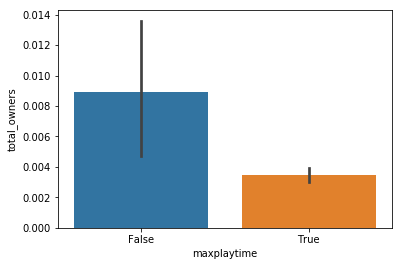

In [0]:
sns.barplot(X_train['maxplaytime'] <= 180, y_train);

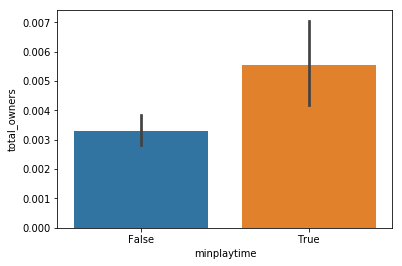

In [0]:
sns.barplot(X_train['minplaytime'] >= 90, y_train);

In [0]:
features.tolist()

['yearpublished',
 'minplayers',
 'maxplayers',
 'playingtime',
 'minplaytime',
 'maxplaytime',
 'minage']